In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_classif, RFE
from sklearn.impute import IterativeImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.svm import SVC
from ydata_profiling import ProfileReport
from yellowbrick.classifier import ConfusionMatrix, ROCAUC, ClassificationReport
from yellowbrick.features import PCA as PCAViz
from yellowbrick.model_selection import CVScores

from fwi_predict.wq import get_in_required_range, WQ_RANGES

In [2]:
# Function to create train-test splits for each target
def create_stratified_splits(df, target_cols, test_size=0.2, random_state=42):
    splits = {}
    for target in target_cols:
        # Drop rows with missing target values
        df_clean = df[df[target].astype(bool)]
        
        # Split features and target
        X = df_clean.drop(target_cols, axis=1)
        y = df_clean[target]

        le = LabelEncoder()
        ye = le.fit_transform(y)
        
        # Create stratified split
        X_train, X_test, y_train, y_test = train_test_split(
            X, ye, test_size=test_size, 
            stratify=ye, random_state=random_state
        )
        
        splits[target] = {
            'X_train': X_train, 'X_test': X_test,
            'y_train': y_train, 'y_test': y_test,
            'label_encoder': le
        }
    
    return splits

In [3]:
# Define dimensionality reduction approaches
dim_reduction = {
    'SelectKBest': SelectKBest(score_func=f_classif, k=20),
    'PCA': PCA(n_components=0.95),  # Preserve 95% of variance
    'L1_Selection': SelectFromModel(LassoCV(cv=5)),
    'RFE': RFE(estimator=RandomForestClassifier(n_estimators=100), n_features_to_select=20)
}

# Define models and their parameter grids
models = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'dim_reduction': ['SelectKBest', 'L1_Selection', 'RFE'],
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [10, 20, 30, None],
            'classifier__min_samples_split': [5, 30]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'dim_reduction': ['SelectKBest', 'L1_Selection', 'RFE'],
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__max_depth': [3, 5, 7]
        }
    } #,
    # 'SVM': {
    #     'model': SVC(probability=True),
    #     'needs_imputation': True,  # Needs imputation
    #     'params': {
    #         'dim_reduction': ['SelectKBest', 'PCA', 'L1_Selection'],
    #         'classifier__C': [0.1, 1.0, 10.0],
    #         'classifier__kernel': ['rbf', 'linear']
    #     }
    # }
}

# Function to analyze feature importance and dimensionality
def plot_feature_importance(X_train, y_train):
    # Feature importance using permutation importance
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    
    # Calculate permutation importance
    perm_importance = permutation_importance(rf, X_train, y_train, 
                                             n_repeats=10, n_jobs=-1, random_state=42)
    
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': perm_importance.importances_mean
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
    plt.title('Top 20 Most Important Features (Permutation Importance)')
    plt.show()
    
    return feature_importance

# Function to create pipeline with dimensionality reduction
def create_pipeline(model_info, dim_reduction_method):
   
    steps = [
        ('imputer', IterativeImputer(random_state=42)),
        ('scaler', StandardScaler()),
        ('dim_reduction', dim_reduction[dim_reduction_method]),
        ('classifier', model_info['model'])
    ]

    return Pipeline(steps)

# Function to train and evaluate models
def train_evaluate_models(X_train, X_test, y_train, y_test, target_name):
    results = {}
    
    # Analyze feature importance first
    feature_importance = plot_feature_importance(X_train, y_train)
    
    # Create figure for plotting
    plt.figure(figsize=(20, 15))
    
    for idx, (name, model_info) in enumerate(models.items()):
        print(f"\nTraining {name}...")
        
        # Create parameter grid including dimensionality reduction methods
        param_grid = model_info['params'].copy()
        dim_reduction_methods = param_grid.pop('dim_reduction')
        
        best_score = -np.inf
        best_pipeline = None
        
        # Try each dimensionality reduction method
        for dim_method in dim_reduction_methods:
            pipeline = create_pipeline(model_info, dim_method)
            
            # Create CV object
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            
            # Perform grid search
            grid_search = GridSearchCV(
                pipeline, param_grid,
                cv=cv, scoring='accuracy', n_jobs=-1
            )
            
            # Fit model
            grid_search.fit(X_train, y_train)
            
            # Update best model if necessary
            if grid_search.best_score_ > best_score:
                best_score = grid_search.best_score_
                best_pipeline = grid_search.best_estimator_
                best_dim_method = dim_method
        
        print(f"Best dimensionality reduction method for {name}: {best_dim_method}")
        print(f"Best CV score: {best_score:.3f}")
        
        # Store best model
        results[name] = best_pipeline
        
        # Plot CV scores
        plt.subplot(3, 2, idx+1)
        visualizer = CVScores(best_pipeline, cv=cv, scoring='accuracy')
        visualizer.fit(X_train, y_train)
        visualizer.show()
        
    plt.tight_layout()
    plt.show()
    
    return results

# Function to compare model performances
def compare_models(models_dict, X_test, y_test):
    # Create subplots for different visualizations
    fig, axes = plt.subplots(len(models_dict), 3, figsize=(20, 5*len(models_dict)))
    
    for idx, (name, model) in enumerate(models_dict.items()):
        # Confusion Matrix
        cm = ConfusionMatrix(model, ax=axes[idx, 0])
        cm.fit(X_test, y_test)
        cm.score(X_test, y_test)
        cm.ax.set_title(f'{name} - Confusion Matrix')
        
        # ROC Curve
        roc = ROCAUC(model, ax=axes[idx, 1])
        roc.fit(X_test, y_test)
        roc.score(X_test, y_test)
        roc.ax.set_title(f'{name} - ROC Curve')
        
        # Classification Report
        cr = ClassificationReport(model, ax=axes[idx, 2])
        cr.fit(X_test, y_test)
        cr.score(X_test, y_test)
        cr.ax.set_title(f'{name} - Classification Report')
    
    plt.tight_layout()
    plt.show()


In [7]:
# Load data and remove columns that we don't want for training
predict_df = pd.read_csv("../data/predict_dfs/train/measurements_with_metadata_predict_df.csv")

predict_df = predict_df.drop(columns=['sample_idx', 'pond_id', 'region', 'farm_id', 'group',
                                      'treatment_group', 'sample_dt', 'fish_per_acre',
                                      'species', 'primary_productivity_gpp_mg_per_L',
                                      'geometry'])
predict_df = predict_df.loc[:, ~predict_df.columns.str.startswith('forecast_creation_dt')]
predict_df = predict_df.loc[:, ~predict_df.columns.str.startswith('forecast_hour')]

# Get parameters for classification problem
for param in WQ_RANGES.keys():
  range_name = param.split('_')[0] + '_in_range'
  predict_df[range_name] = get_in_required_range(param, predict_df[param], predict_df['time_of_day'])

predict_df = predict_df.drop(columns='time_of_day') # Don't make this earlier actually.
predict_df = predict_df.drop(columns='Unnamed: 0')

classify_df = predict_df.loc[:, ~predict_df.columns.isin(WQ_RANGES.keys())]
regress_df = predict_df[predict_df.columns[~predict_df.columns.str.endswith('_in_range')].tolist()]
# predict_df.head()

In [5]:
# predict_df.columns.tolist()


Processing target: do_in_range


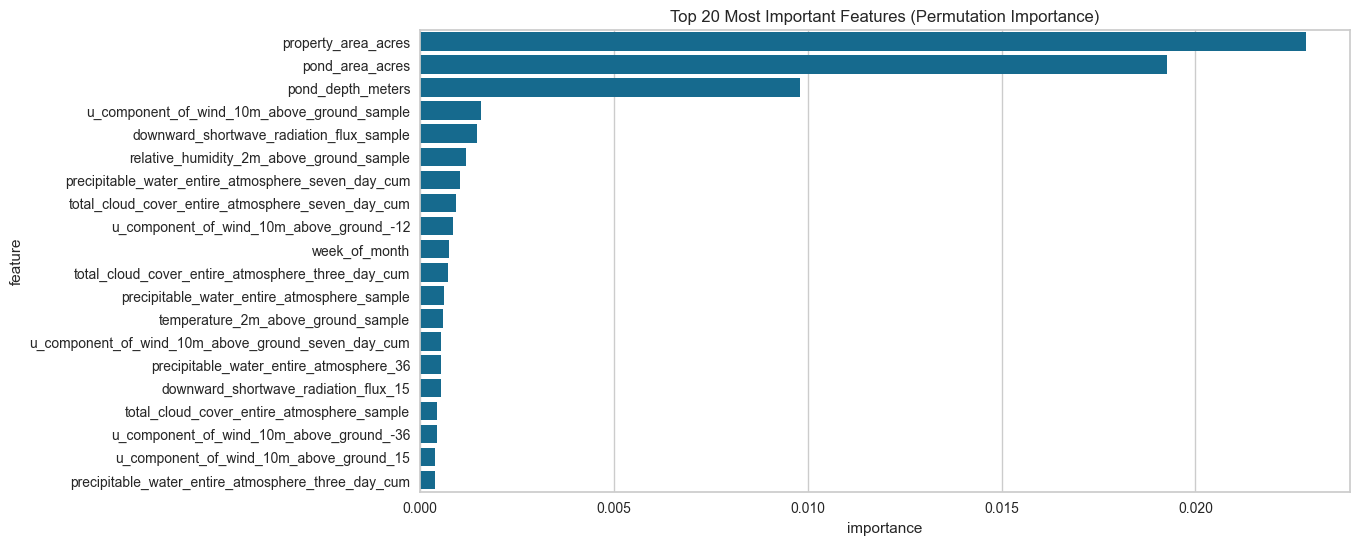


Training Random Forest...


c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [8] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08834699588965123, tolerance: 0.07415371794871782
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

KeyboardInterrupt: 

<Figure size 2000x1500 with 0 Axes>

In [8]:
# Assuming classify df is your dataset and target_columns is a list of your target columns
target_columns = ['do_in_range', 'ph_in_range', 'ammonia_in_range', 'turbidity_in_range']  # Replace with actual target column names

# Create splits for each target
splits = create_stratified_splits(classify_df, target_columns)

# For each target, train and evaluate models
for target in target_columns:
    print(f"\nProcessing target: {target}")
    print("=" * 50)
    
    # Get split data for current target
    split_data = splits[target]
    
    # Train and evaluate models
    trained_models = train_evaluate_models(
        split_data['X_train'], split_data['X_test'],
        split_data['y_train'], split_data['y_test'],
        target
    )
    
    # Compare model performances
    compare_models(trained_models, split_data['X_test'], split_data['y_test'])

The permutation importance is now very different from when we had less featrures. I suspect you have too many features.

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

from typing import Union


def cluster_correlated_features(X: Union[np.ndarray, pd.DataFrame]):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
  corr = spearmanr(X).correlation

  # Ensure the correlation matrix is symmetric
  corr = (corr + corr.T) / 2
  np.fill_diagonal(corr, 1)

  # We convert the correlation matrix to a distance matrix before performing
  # hierarchical clustering using Ward's linkage.
  distance_matrix = 1 - np.abs(corr)
  dist_linkage = hierarchy.ward(squareform(distance_matrix))
  dendro = hierarchy.dendrogram(
      dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
  )
  dendro_idx = np.arange(0, len(dendro["ivl"]))

  ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
  ax2.set_xticks(dendro_idx)
  ax2.set_yticks(dendro_idx)
  ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
  ax2.set_yticklabels(dendro["ivl"])
  _ = fig.tight_layout()

In [20]:
# Generate heatmap of correlations between y vars (as columns) and X vars (as rows)
from typing import Dict, List

def plot_outcome_feature_correlations(df: pd.DataFrame,
                                      outcome_cols: List,
                                      annot_kws: Dict = None,
                                      cbar_kws: Dict = None) -> None:
  """Plot heatmap of correlations between outcomes and features."""
  if annot_kws is None:
    annot_kws = {}

  if cbar_kws is None:
    cbar_kws = {}

  feature_cols = df.columns[~df.columns.isin(outcome_cols)].tolist()
  corr = df.corr().loc[feature_cols, outcome_cols]
  corr = corr.loc[corr.apply(lambda x: sum(abs(x)), axis=1).sort_values(ascending=False).index]

  fig, ax = plt.subplots(figsize=(6, 30))
  sns.heatmap(corr,
              ax=ax,
              cmap='coolwarm',
              center=0,
              annot=True,
              annot_kws=annot_kws,
              fmt=".2f",
              vmin=-1,
              vmax=1, # Align colorbar with top of plot
              cbar_kws=cbar_kws) 

  # Make the y var labels on the top
  ax.xaxis.tick_top() # Rotate them 45 degrees
  ax.xaxis.set_label_position('top')
  plt.xticks(rotation=45, rotation_mode='anchor', ha='left')
  ax.set_xlabel("Outcomes")
  ax.set_ylabel("Features")
  ax.set_title("Outcome/feature correlations", fontsize=16)

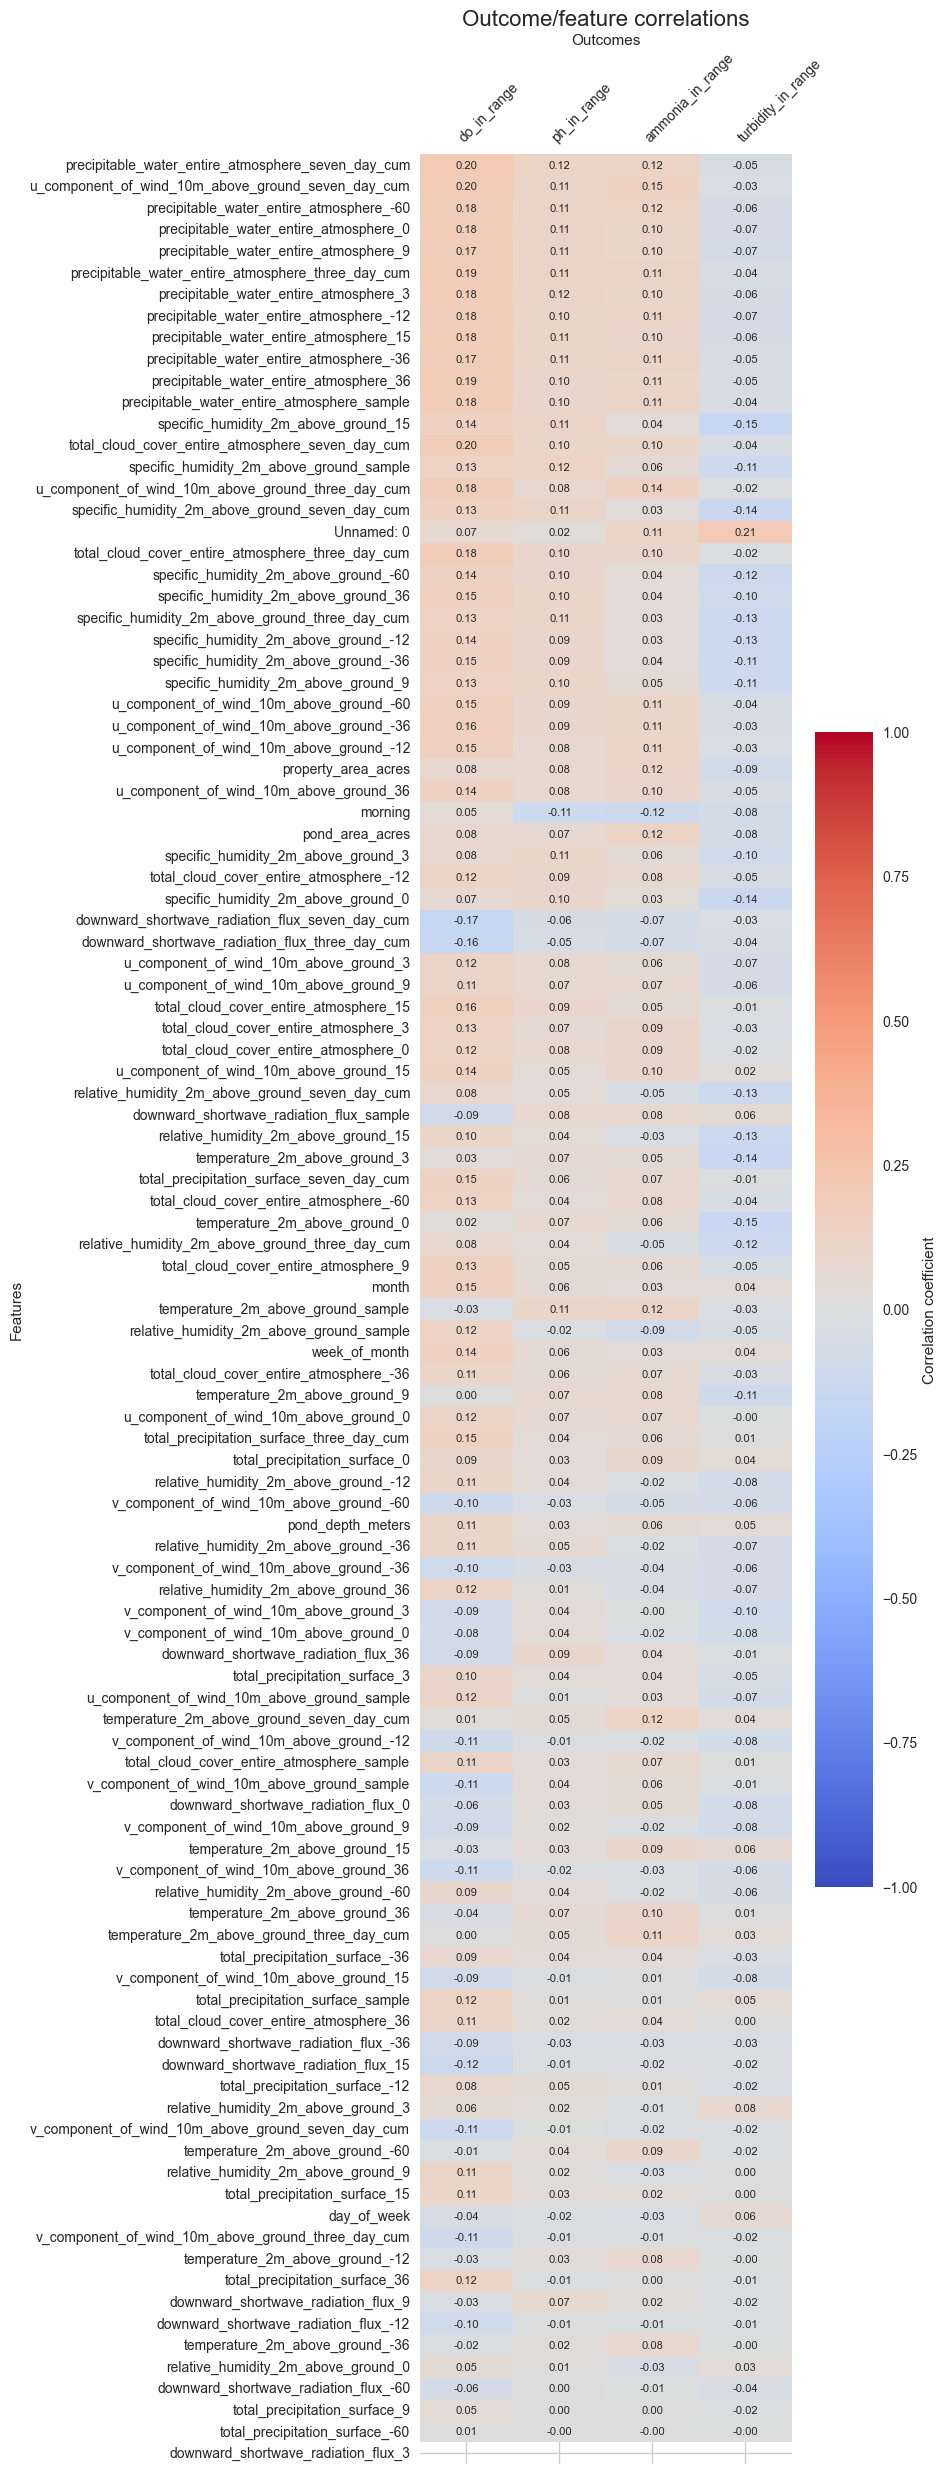

In [22]:
classify_df_oor = classify_df.copy()
for outcome in target_columns:
  classify_df_oor[outcome] = classify_df_oor[outcome].case_when(
    [(classify_df_oor[outcome] == 'within', False),
     (classify_df_oor[outcome].isin(['above', 'below']), True),
     (classify_df_oor[outcome].isin(['', np.nan]), np.nan)]
  )

plot_outcome_feature_correlations(classify_df_oor,
                                  target_columns,
                                  annot_kws={'fontsize': 8},
                                  cbar_kws={'shrink':0.5, 'label': 'Correlation coefficient'})

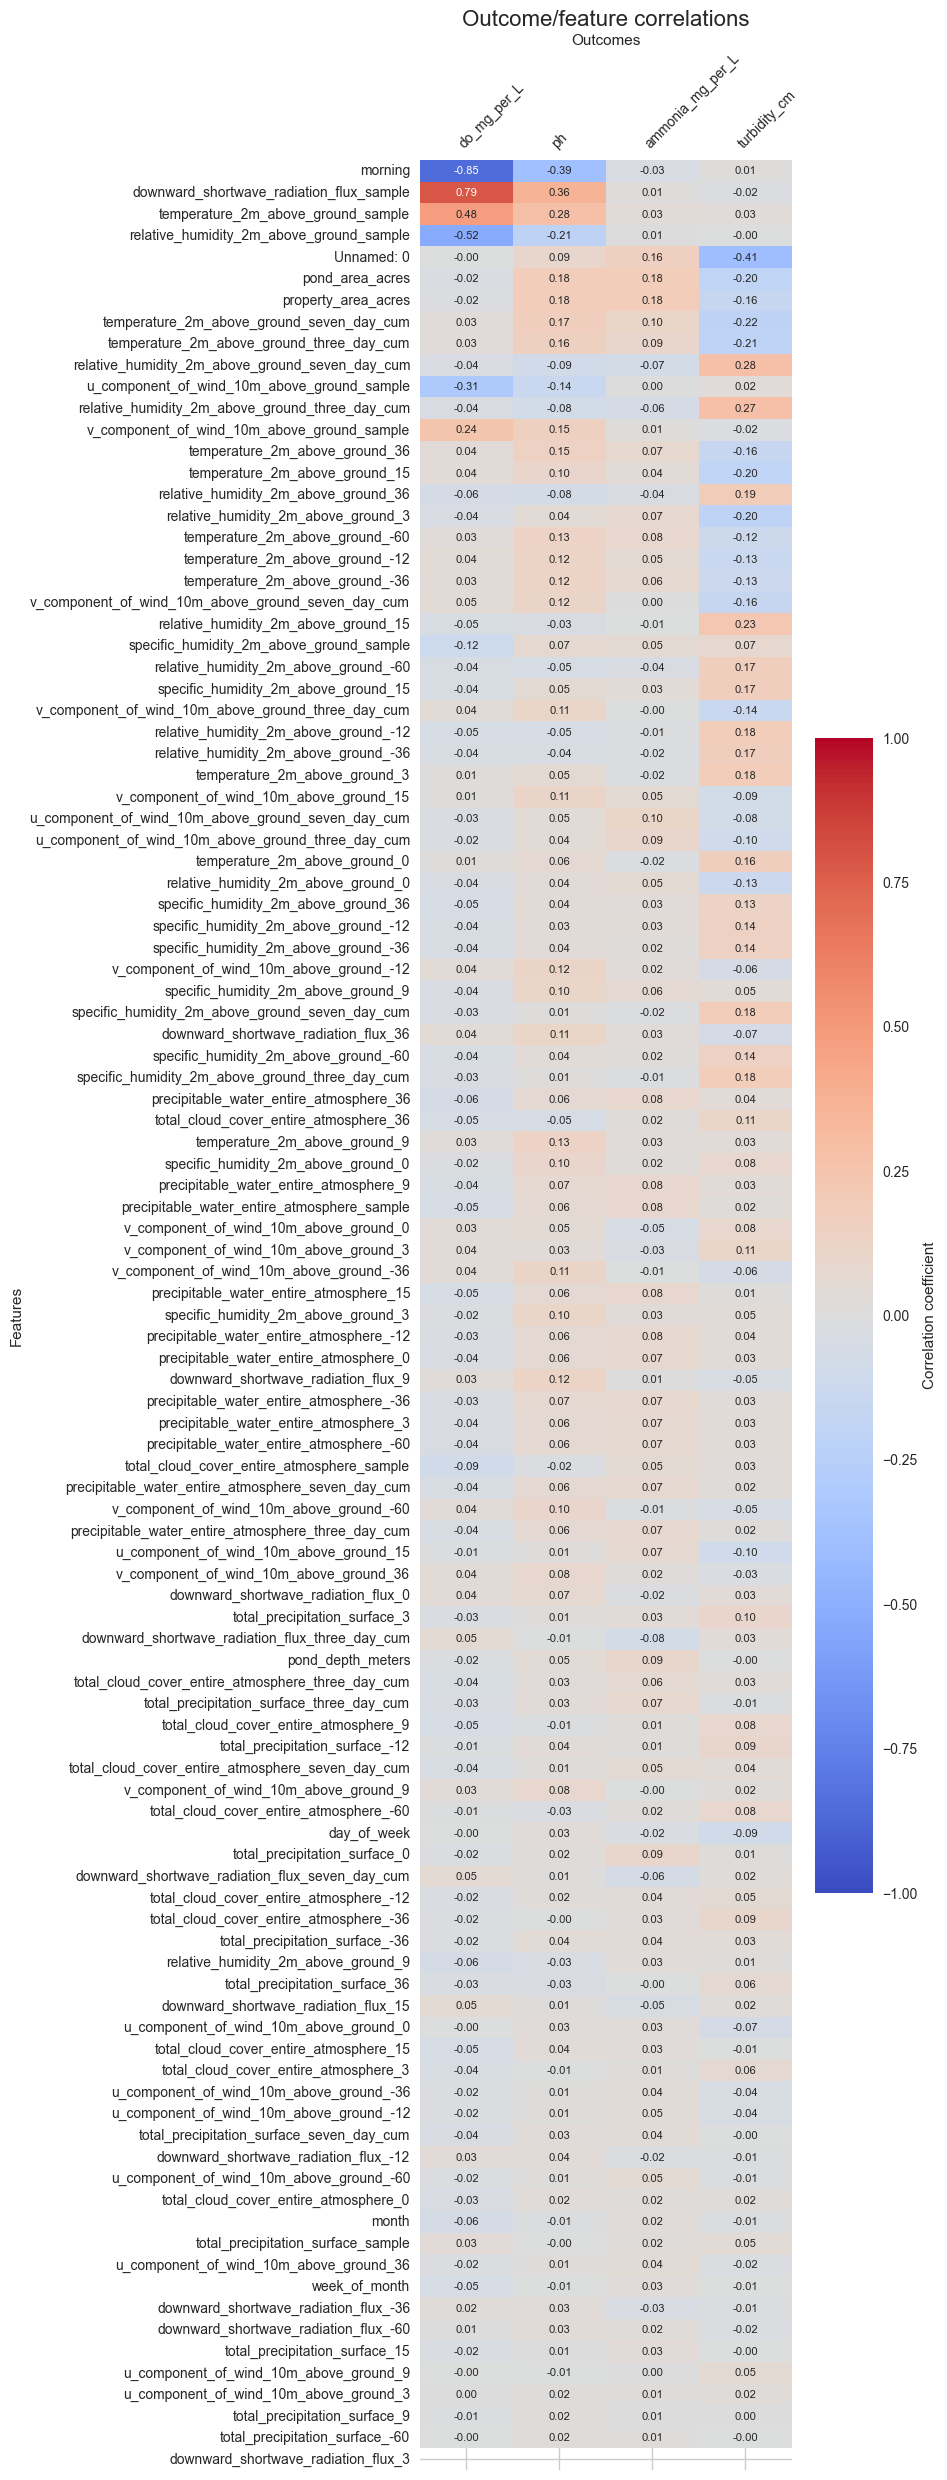

In [21]:
regress_cols = list(WQ_RANGES.keys())
plot_outcome_feature_correlations(regress_df,
                                  regress_cols,
                                  annot_kws={'fontsize': 8},
                                  cbar_kws={'shrink':0.5, 'label': 'Correlation coefficient'})